# Web Scraping and Introductory Data Analysis

Welcome to Homework 0, where we will delve into web scraping and perform an introductory data analysis. This homework will be a hands-on exercise that will help you become familiar with the process of extracting data from websites and conducting basic statistical analysis. 

## Objectives

By the end of this homework, you will be able to:

1. Set up a Python environment with the necessary libraries for web scraping and data analysis.
2. Write a web scraping script using Beautiful Soup and Selenium to collect data from a website.
3. Sample from the collected dataset and compare the statistics of the sample and the population.
   
## Tasks

1. **Environment Setup**: Install the required libraries such as Beautiful Soup, Selenium, pandas, numpy, matplotlib, and seaborn.

2. **Web Scraping**: Write a script to scrape transaction data from [Etherscan.io](https://etherscan.io/txs). Use Selenium to interact with the website and Beautiful Soup to parse the HTML content.

3. **Data Sampling**: Once the data is collected, create a sample from the dataset. Compare the sample statistics (mean and standard deviation) with the population statistics.


## Deliverables

1. A Jupyter notebook with all the code and explanations.
2. A detailed report on the findings, including the comparison of sample and population statistics.
Note: You can include the report in your notebook.

## Getting Started

Begin by setting up your Python environment and installing the necessary libraries. Then, proceed with the web scraping task, ensuring that you handle any potential issues such as rate limiting. Once you have the data, move on to the data sampling and statistical analysis tasks. 

Remember to document your process and findings in the Jupyter notebook, and to include visualizations where appropriate to illustrate your results. <br>
Good luck, and happy scraping!

## Data Collection (Etherscan)

In this section, we will use web scraping to gather transaction data from the Ethereum blockchain using the Etherscan block explorer. Our objective is to collect transactions from the **last 10 blocks** on Ethereum.

To accomplish this task, we will employ web scraping techniques to extract the transaction data from the Etherscan website. The URL we will be targeting for our data collection is:

[https://etherscan.io/txs](https://etherscan.io/txs)

### Steps

1. **Navigate to the URL**: Use Selenium to open the Etherscan transactions page in a browser.

2. **Locate the Transaction Data**: Identify the HTML elements that contain the transaction data for the specified block range.

3. **Extract the Data**: Write a script to extract the transaction details e.g. Hash, Method, Block, etc.

4. **Handle Pagination**: If the transactions span multiple pages, implement pagination handling to navigate through the pages and collect all relevant transaction data.

5. **Store the Data**: Save the extracted transaction data into a structured format, such as a CSV file or a pandas DataFrame, for further analysis.

### Considerations

- **Rate Limiting**: Be mindful of the website's rate limits to avoid being blocked. Implement delays between requests if necessary.
- **Dynamic Content**: The Etherscan website may load content dynamically. Ensure that Selenium waits for the necessary elements to load before attempting to scrape the data.
- **Data Cleaning**: After extraction, clean the data to remove any inconsistencies or errors that may have occurred during the scraping process.

### Resources

- [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [Selenium Documentation](https://selenium-python.readthedocs.io/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Ethereum](https://ethereum.org/en/)

## Our code

First we make a new csv file which will be used for storing the data later, then we get the number of last 10 blocks and finally we extract the data for each block. After testing we found out there is no need for waiting for the data to be loaded nor is there any need for limiting the requests rate, so we commented the sleeps. We extract two set of data one is the recent 10 blocks and the other is 10 random blocks from all the existing blocks on the website. Some blocks have no data so we if any exception is raised we skip the block.

**Importing necessary libraries**

In [61]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from time import sleep
import pandas as pd
import csv
import matplotlib.pyplot as plt
# from scipy.stats import norm
import numpy as np
import random
import math
import scipy.stats as stats
import numpy as np
import seaborn as sns

**Making a new CSV file for storing the data**

In [62]:
def make_new_csv(file_addr):
    with open(file_addr, mode='w') as transactions_file:
        transactionCSV = csv.writer(transactions_file)
        transactionCSV.writerow(
            ['Transaction Hash', 'Method', 'Block Number', 'Age', 'From', 'To', 'Value', 'Txn Fee', 'Warning', 'Danger'])

**Writing data to the CSV file**

In [63]:
def write_to_csv(transactionList, file_addr):
    with open(file_addr, mode='a', encoding='utf-8') as transactions_file:
        transactionCSV=csv.writer(transactions_file)
        for transaction in transactionList:
            tds=transaction.find_all('td')
            transaction_hash=tds[1].text[4:-4]
            method = tds[2].text
            block_number = tds[3].text
            age = tds[5].text
            transaction_from = tds[7].text[4:-5]
            transaction_to = tds[9].text[4:-7]
            value = tds[10].text[:-4]
            txn_fee = tds[11].text
            warning = pd.NA
            if tds[1].find('span', {'class': 'text-warning'}) is not None:
                warning = tds[1].find(
                    'span', {'class': 'text-warning'}).get("data-bs-title")
            danger = pd.NA
            if tds[1].find('span', {'class': 'text-danger'}) is not None:
                danger = tds[1].find(
                    'span', {'class': 'text-danger'}).get("data-bs-title")
            transactionCSV.writerow([transaction_hash, method,block_number,age,transaction_from,transaction_to,value,txn_fee,warning,danger])

**Scraping data from a specific block**

In [64]:
class BlockNotFound(Exception):
    pass

In [65]:
def scrape_block_data(block_number, driver, file_addr):
    driver.get(f'https://etherscan.io/txs?block={block_number}')
    page = driver.page_source
    soup = bs(page, 'html.parser')
    pagination = soup.find_all(
        'ul', {'class': 'pagination pagination-sm mb-0'})
    if not pagination:
        raise BlockNotFound()
    number_of_pages = int(pagination[0].find_all('li')[-3].text.split()[-1])
    for p in range(number_of_pages):
        driver.get(
            f'https://etherscan.io/txs?block={block_number}&p={p+1}')
        sleep(0.1)
        page = driver.page_source
        soup = bs(page, 'html.parser')
        content = soup.find('tbody', {'class': 'align-middle text-nowrap'})
        transactionList = content.find_all('tr')
        write_to_csv(transactionList, file_addr)

**Scraping the recent blocks**

In [66]:
def scrape_recent_transactions(number_of_blocks, file_addr):
    make_new_csv(file_addr)
    driver = webdriver.Chrome()
    driver.get(f'https://etherscan.io/blocks')
    sleep(0.1)
    page = driver.page_source
    soup = bs(page, 'html.parser')
    blocks = soup.find('tbody', {'class': 'align-middle text-nowrap'})
    last_block = int(blocks.find_all('td')[0].text)
    cnt_of_extracted_blocks=0
    i=0
    while cnt_of_extracted_blocks<number_of_blocks:
        sleep(0.1)
        try:
            scrape_block_data(last_block-i, driver, file_addr)
            i+=1
        except BlockNotFound:
            continue
        cnt_of_extracted_blocks+=1
    driver.close()

**Scraping random blocks**

In [67]:
def scrape_random_transactions(number_of_blocks, file_addr):
    make_new_csv(file_addr)
    driver = webdriver.Chrome()
    driver.get(f'https://etherscan.io/blocks')
    sleep(0.1)
    page = driver.page_source
    soup = bs(page, 'html.parser')
    blocks = soup.find('tbody', {'class': 'align-middle text-nowrap'})
    last_block = int(blocks.find_all('td')[0].text)
    extracted_blocks=set()
    cnt_of_extracted_blocks=0
    while cnt_of_extracted_blocks < number_of_blocks:
        sleep(0.1)
        try:
            block = random.randint(0, last_block)
            if block in extracted_blocks:
                continue
            extracted_blocks.add(block)
            scrape_block_data(block, driver, file_addr)
        except BlockNotFound:
            continue
        cnt_of_extracted_blocks+=1
    driver.close()

In [68]:
scrape_recent_transactions(10,"transactions.csv")
scrape_random_transactions(10,"transactions_random.csv")

## Data Analysis

Now that we have collected the transaction data from Etherscan, the next step is to perform conduct an initial analysis. This task will involve the following steps:

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by converting data types, removing any irrelevant information, and handling **duplicate** values.

3. **Statistical Analysis**: Calculate the mean and standard deviation of the population. Evaluate these statistics to understand the distribution of transaction values. The analysis and plotting will be on **Txn Fee** and **Value**.

4. **Visualization**: This phase involves the creation of visual representations to aid in the analysis of transaction values. The visualizations include:
    - A histogram for each data column, which provides a visual representation of the data distribution. The selection of bin size is crucial and should be based on the data's characteristics to ensure accurate representation. Provide an explanation on the bin size selection!
    - A normal distribution plot fitted alongside the histogram to compare the empirical distribution of the data with the theoretical normal distribution.
    - A box plot and a violin plot to identify outliers and provide a comprehensive view of the data's distribution.

### Deliverables

The project aims to deliver the following deliverables:

- A refined pandas DataFrame containing the transaction data, which has undergone thorough cleaning and is ready for analysis.
- A simple statistical analysis evaluating the population statistics, offering insights into the distribution of transaction values and fees.
- A set of visualizations showcasing the distribution of transaction values for the population. These visualizations include histograms, normal distribution plots, box plots, and violin plots, each serving a specific purpose in the analysis.

### Getting Started

The project starts with the importing of transaction data into a pandas DataFrame, setting the stage for data manipulation and analysis. Subsequent steps involve the cleaning of the data to ensure its quality and reliability. Followed by the calculation of population statistics. Finally, a series of visualizations are created to visually analyze the distribution of transaction values and fees.

## Load Recent blocks and cleaning:

In [199]:
# load data
recent_blocks_df = pd.read_csv('transactions.csv')

warning_df = recent_blocks_df[recent_blocks_df['Warning'] == "Error in Internal Txn : execution reverted"] 
danger_df = recent_blocks_df[recent_blocks_df['Danger'] == "Error in Main Txn : execution reverted"] 

# Convert 'Value' and 'Txn Fee' to numeric, forcing non-numeric values to NaN
recent_blocks_df['Value'] = pd.to_numeric(recent_blocks_df['Value'], errors='coerce')
recent_blocks_df['Txn Fee'] = pd.to_numeric(recent_blocks_df['Txn Fee'], errors='coerce')

# Drop rows with NaN in specific columns if conversion resulted in NaN values
recent_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)

# Filtering transactions based on 'Value' and 'Txn Fee' ranges
recent_blocks_df = recent_blocks_df[((recent_blocks_df['Value'] > 0) & (recent_blocks_df['Value'] < 0.45)) & ((recent_blocks_df['Txn Fee'] > 0) & (recent_blocks_df['Txn Fee'] < 0.045))]

# Adding a new column for the sum of 'Value' and 'Txn Fee'
recent_blocks_df['Total'] = recent_blocks_df['Value'] + np.multiply(recent_blocks_df['Txn Fee'],recent_blocks_df['Value'])

# Drop duplicates
recent_blocks_df.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)


## Statistical Analysis on Recent blocks:

In [204]:
recent_blocks_df.describe()

,Block Number,Value,Txn Fee,Total
count,5.680000e+02,5.680000e+02,568.000000,5.680000e+02
mean,1.938906e+07,8.399295e-02,0.003021,8.436085e-02
std,2.694969e+00,9.783327e-02,0.003937,9.831927e-02
min,1.938906e+07,1.000000e-09,0.000949,1.028447e-09
25%,1.938906e+07,1.000000e-02,0.000982,1.001006e-02
50%,1.938906e+07,4.000000e-02,0.001019,4.014686e-02
75%,1.938907e+07,1.200000e-01,0.003950,1.205801e-01
max,1.938907e+07,4.493408e-01,0.041734,4.497937e-01


value: 
mean= 0.0840
std= 0.0978
Txn Fee: 
mean= 0.0030
std= 0.0039
Total: 
mean= 0.0844
std= 0.0983


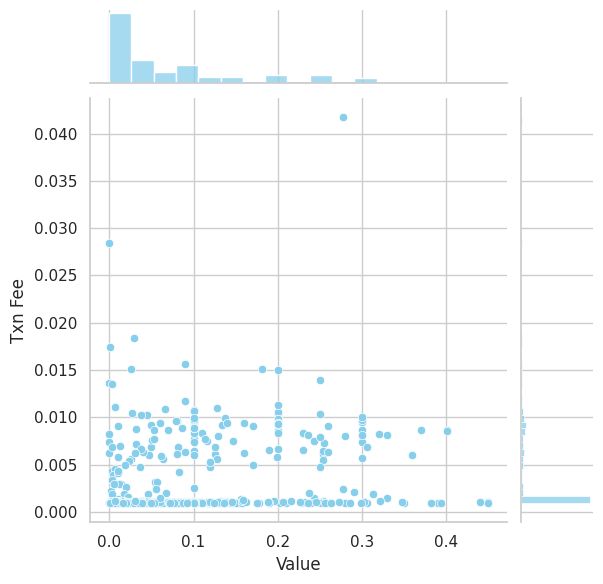

In [200]:
# mean and std
mean_value = recent_blocks_df['Value'].mean()
std_value = recent_blocks_df['Value'].std()
mean_txn_fee = recent_blocks_df['Txn Fee'].mean()
std_txn_fee = recent_blocks_df['Txn Fee'].std()
mean_total = recent_blocks_df['Total'].mean()
std_total = recent_blocks_df['Total'].std()

print("value: " )
print(f"mean= {mean_value:.4f}")
print(f"std= {std_value:.4f}")
print("Txn Fee: " )
print(f"mean= {mean_txn_fee:.4f}")
print(f"std= {std_txn_fee:.4f}")
print("Total: " )
print(f"mean= {mean_total:.4f}")
print(f"std= {std_total:.4f}")

sns.set_theme(style="whitegrid")
sns.jointplot(x="Value", y="Txn Fee", data=recent_blocks_df, kind="scatter", color = "skyblue")
plt.show()

## Load Random blocks and cleaning:

In [201]:
# load data
random_blocks_df = pd.read_csv('transactions_random.csv')

# Convert 'Value' and 'Txn Fee' to numeric, forcing non-numeric values to NaN
random_blocks_df['Value'] = pd.to_numeric(random_blocks_df['Value'], errors='coerce')
random_blocks_df['Txn Fee'] = pd.to_numeric(random_blocks_df['Txn Fee'], errors='coerce')

# Drop rows with NaN in specific columns if conversion resulted in NaN values
random_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)

# Filtering transactions based on 'Value' and 'Txn Fee' ranges
random_blocks_df = random_blocks_df[((random_blocks_df['Value'] > 0) & (random_blocks_df['Value'] < 0.45)) & ((random_blocks_df['Txn Fee'] > 0) & (random_blocks_df['Txn Fee'] < 0.045))]

# Adding a new column for the sum of 'Value' and 'Txn Fee'
random_blocks_df['Total'] = random_blocks_df['Value'] + np.multiply(random_blocks_df['Txn Fee'],random_blocks_df['Value'])

# Drop duplicates
random_blocks_df.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)



## Statistical Analysis on Random blocks

In [205]:
random_blocks_df.describe()

,Block Number,Value,Txn Fee,Warning,Total
count,4.260000e+02,426.000000,426.000000,0.0,426.000000
mean,1.192505e+07,0.085170,0.002904,NaN,0.085428
std,3.432738e+06,0.101284,0.004279,NaN,0.101552
min,4.607556e+06,0.000052,0.000021,NaN,0.000052
25%,1.026952e+07,0.010011,0.000637,NaN,0.010068
50%,1.193301e+07,0.050000,0.001197,NaN,0.050052
75%,1.464150e+07,0.119238,0.003937,NaN,0.119358
max,1.801542e+07,0.449236,0.038974,NaN,0.449425


value: 
mean= 0.0852
std= 0.1013
Txn Fee: 
mean= 0.0029
std= 0.0043
Total: 
mean= 0.0854
std= 0.1016


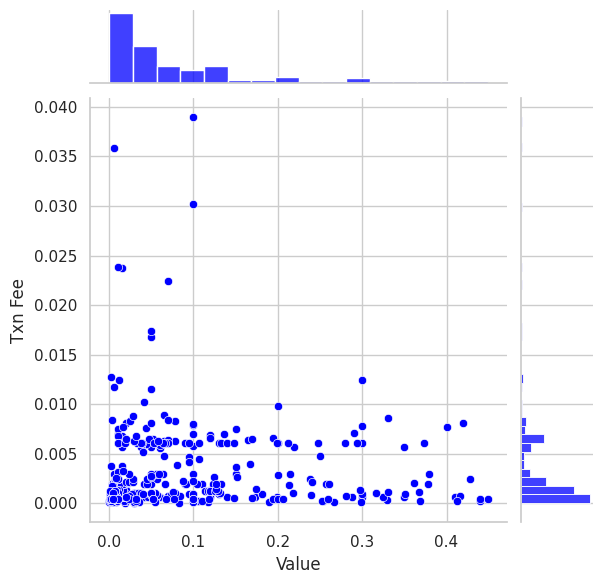

In [202]:
# mean and std
mean_value = random_blocks_df['Value'].mean()
std_value = random_blocks_df['Value'].std()
mean_txn_fee = random_blocks_df['Txn Fee'].mean()
std_txn_fee = random_blocks_df['Txn Fee'].std()
mean_total = random_blocks_df['Total'].mean()
std_total = random_blocks_df['Total'].std()

print("value: " )
print(f"mean= {mean_value:.4f}")
print(f"std= {std_value:.4f}")
print("Txn Fee: " )
print(f"mean= {mean_txn_fee:.4f}")
print(f"std= {std_txn_fee:.4f}")
print("Total: " )
print(f"mean= {mean_total:.4f}")
print(f"std= {std_total:.4f}")

sns.set_theme(style="whitegrid")
sns.jointplot(x="Value", y="Txn Fee", data=random_blocks_df, kind="scatter", color = "blue")
plt.show()

## Visualization

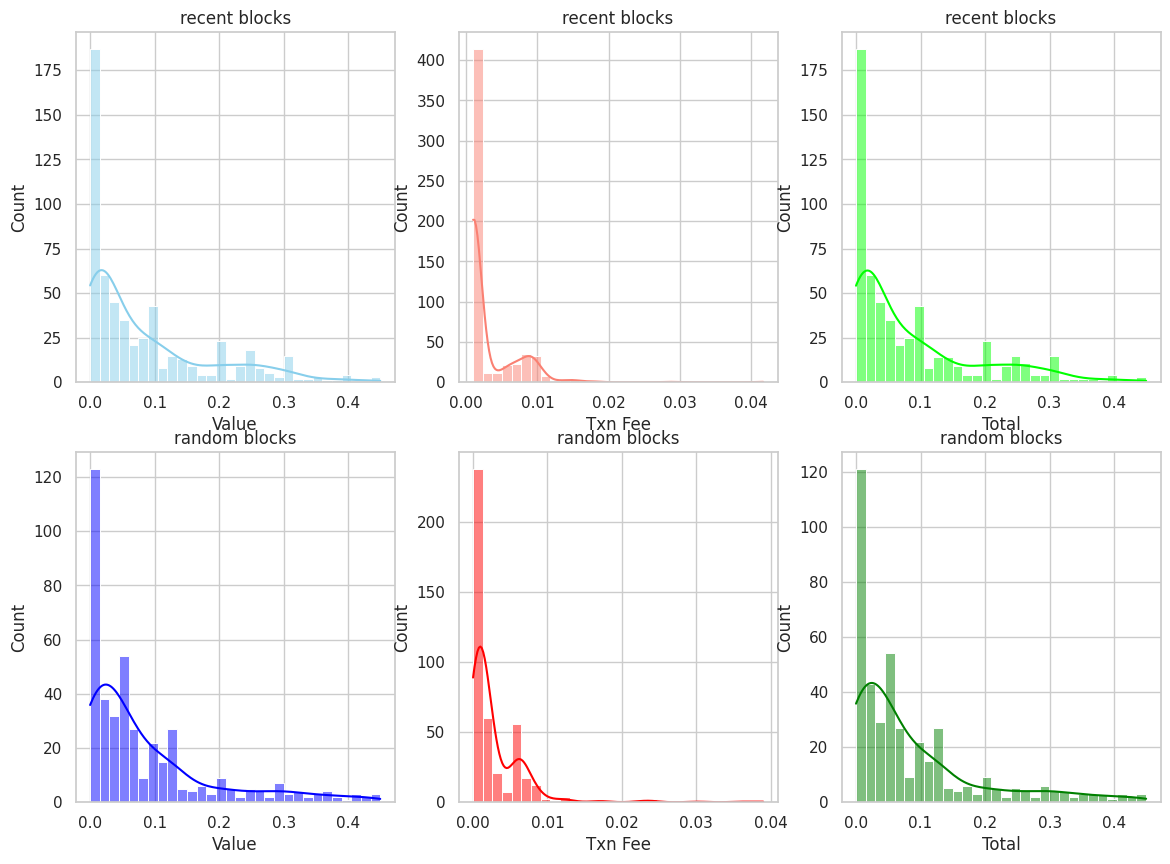

In [203]:
# show hist plot 

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))

datas = [recent_blocks_df, random_blocks_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
titles = ["recent blocks","random blocks"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.histplot(datas[i//3][coulmns[i%3]], bins=30, kde=True, color= colors[i])
    plt.title(titles[i//3])

plt.show()

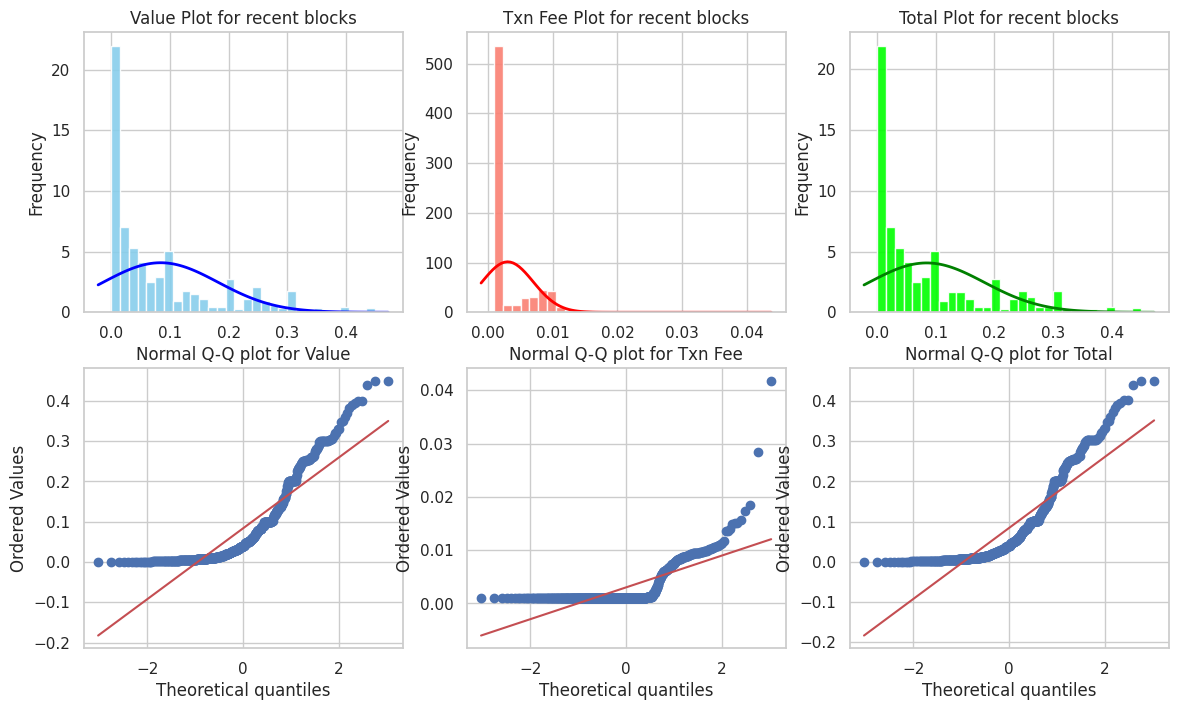

In [176]:
# comparing with normal distribution for recent blocks

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(recent_blocks_df[coulmns[i]])
    recent_blocks_df[coulmns[i]].plot.hist(bins=30, alpha=0.9, density= True, color = colors[i])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, colors[3+i], linewidth=2)
    plt.title(f"{coulmns[i]} Plot for recent blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(recent_blocks_df[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")

plt.show()


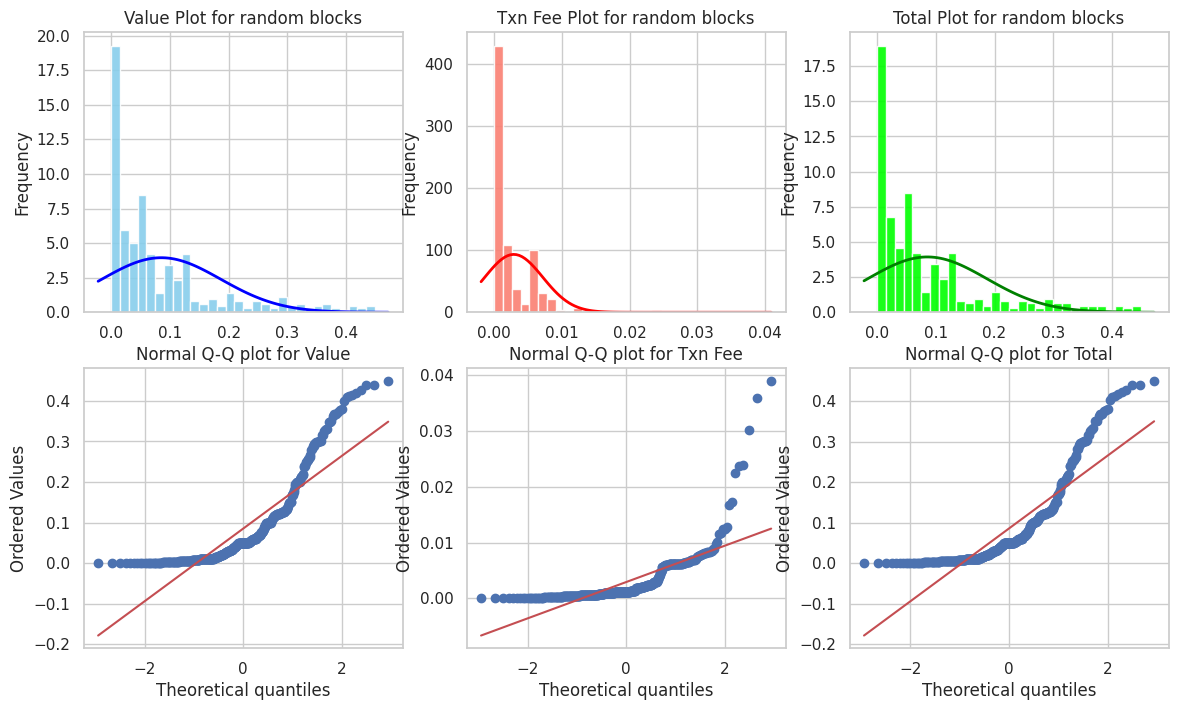

In [175]:
# comparing with normal distribution for random blocks

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(random_blocks_df[coulmns[i]])
    random_blocks_df[coulmns[i]].plot.hist(bins=30, alpha=0.9, density= True, color = colors[i])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, colors[3+i], linewidth=2)
    plt.title(f"{coulmns[i]} Plot for random blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(random_blocks_df[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")

plt.show()


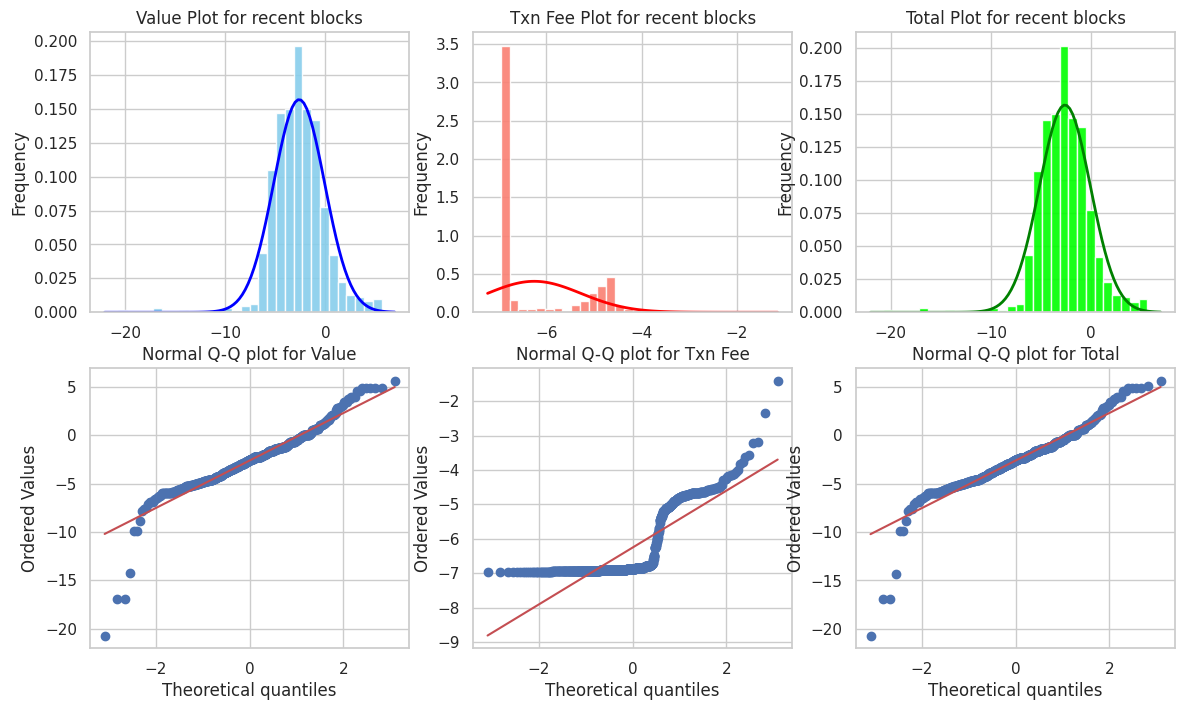

In [174]:
# comparing with log normal distribution for recent blocks

# load data
recent_blocks_df_log = pd.read_csv('transactions.csv')
recent_blocks_df_log['Value'] = pd.to_numeric(recent_blocks_df_log['Value'], errors='coerce')
recent_blocks_df_log['Txn Fee'] = pd.to_numeric(recent_blocks_df_log['Txn Fee'], errors='coerce')
recent_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)
recent_blocks_df_log = recent_blocks_df_log[((recent_blocks_df_log['Value'] > 0)) & ((recent_blocks_df_log['Txn Fee'] > 0))]
recent_blocks_df_log.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)
recent_blocks_df_log['Total'] = recent_blocks_df_log['Value'] + np.multiply(recent_blocks_df_log['Txn Fee'],recent_blocks_df_log['Value'])

# get log
recent_blocks_df_log['Value'] = recent_blocks_df_log['Value'].apply(lambda num: math.log(num))
recent_blocks_df_log['Txn Fee'] = recent_blocks_df_log['Txn Fee'].apply(lambda num: math.log(num))
recent_blocks_df_log['Total'] = recent_blocks_df_log['Total'].apply(lambda num: math.log(num))

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

# plots
for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(recent_blocks_df_log[coulmns[i]])
    recent_blocks_df_log[coulmns[i]].plot.hist(bins=30, color = colors[i] , alpha=0.9 ,density= True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2, color = colors[3 + i])
    plt.title(f"{coulmns[i]} Plot for recent blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(recent_blocks_df_log[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")


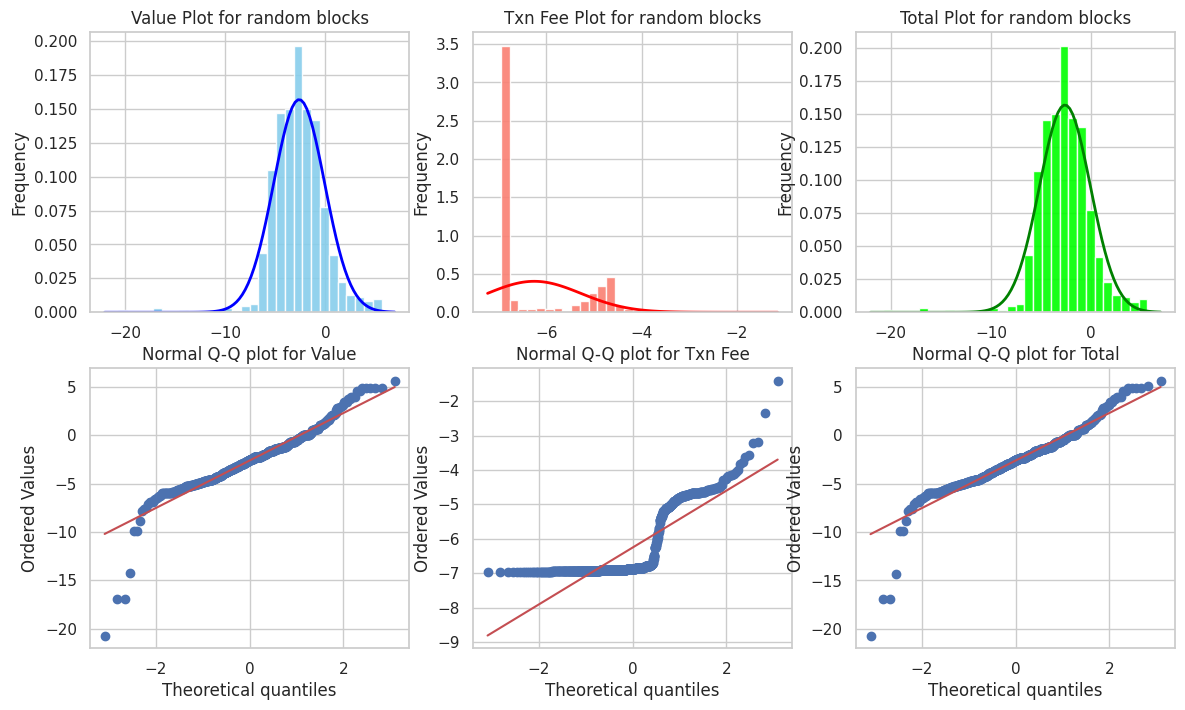

In [173]:
# comparing with log normal distribution for random blocks

# load data
random_blocks_df_log = pd.read_csv('transactions.csv')
random_blocks_df_log['Value'] = pd.to_numeric(random_blocks_df_log['Value'], errors='coerce')
random_blocks_df_log['Txn Fee'] = pd.to_numeric(random_blocks_df_log['Txn Fee'], errors='coerce')
recent_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)
random_blocks_df_log = random_blocks_df_log[((random_blocks_df_log['Value'] > 0)) & ((random_blocks_df_log['Txn Fee'] > 0))]
random_blocks_df_log.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)
random_blocks_df_log['Total'] = random_blocks_df_log['Value'] + np.multiply(random_blocks_df_log['Txn Fee'],random_blocks_df_log['Value'])

# get log
random_blocks_df_log['Value'] = random_blocks_df_log['Value'].apply(lambda num: math.log(num))
random_blocks_df_log['Txn Fee'] = random_blocks_df_log['Txn Fee'].apply(lambda num: math.log(num))
random_blocks_df_log['Total'] = random_blocks_df_log['Total'].apply(lambda num: math.log(num))

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

# plots
for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(random_blocks_df_log[coulmns[i]])
    random_blocks_df_log[coulmns[i]].plot.hist(bins=30, color = colors[i] , alpha=0.9 ,density= True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2, color = colors[3 + i])
    plt.title(f"{coulmns[i]} Plot for random blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(random_blocks_df_log[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")


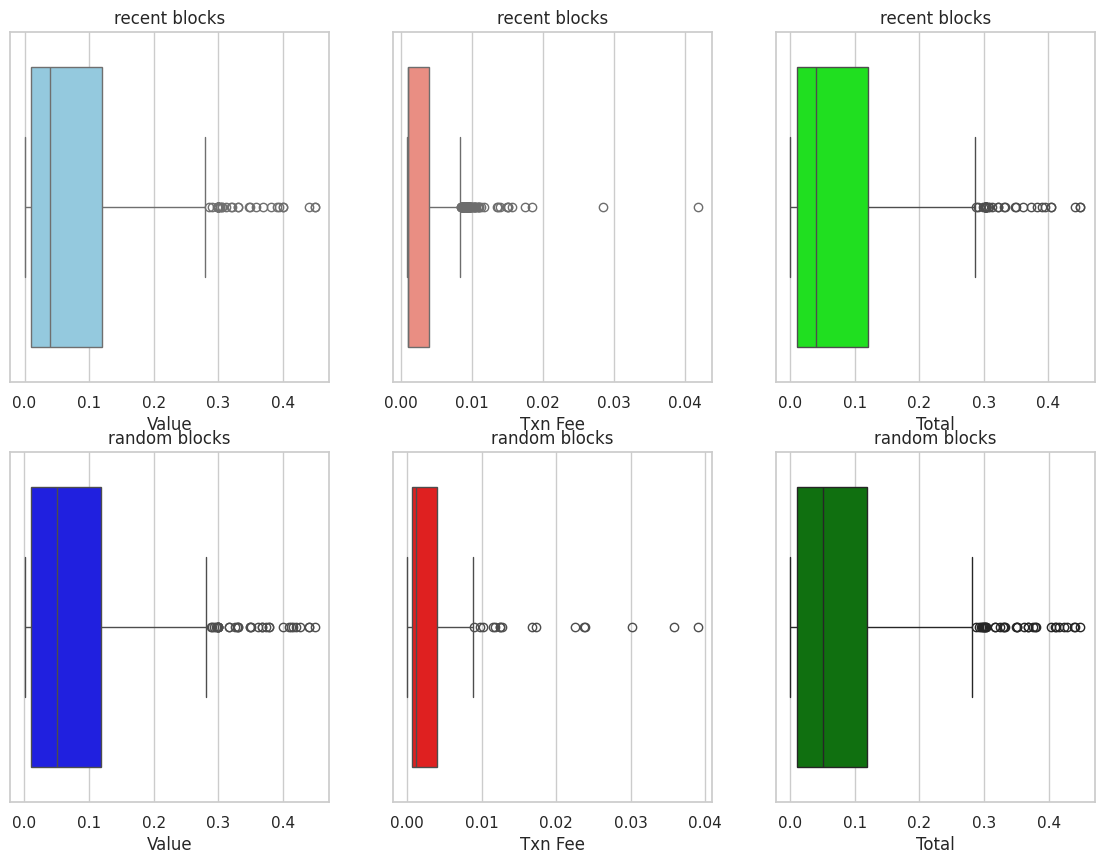

In [168]:
# box plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))

datas = [recent_blocks_df, random_blocks_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
titles = ["recent blocks","random blocks"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.boxplot(x = datas[i//3][coulmns[i%3]], color= colors[i])
    plt.title(titles[i//3])

plt.show()


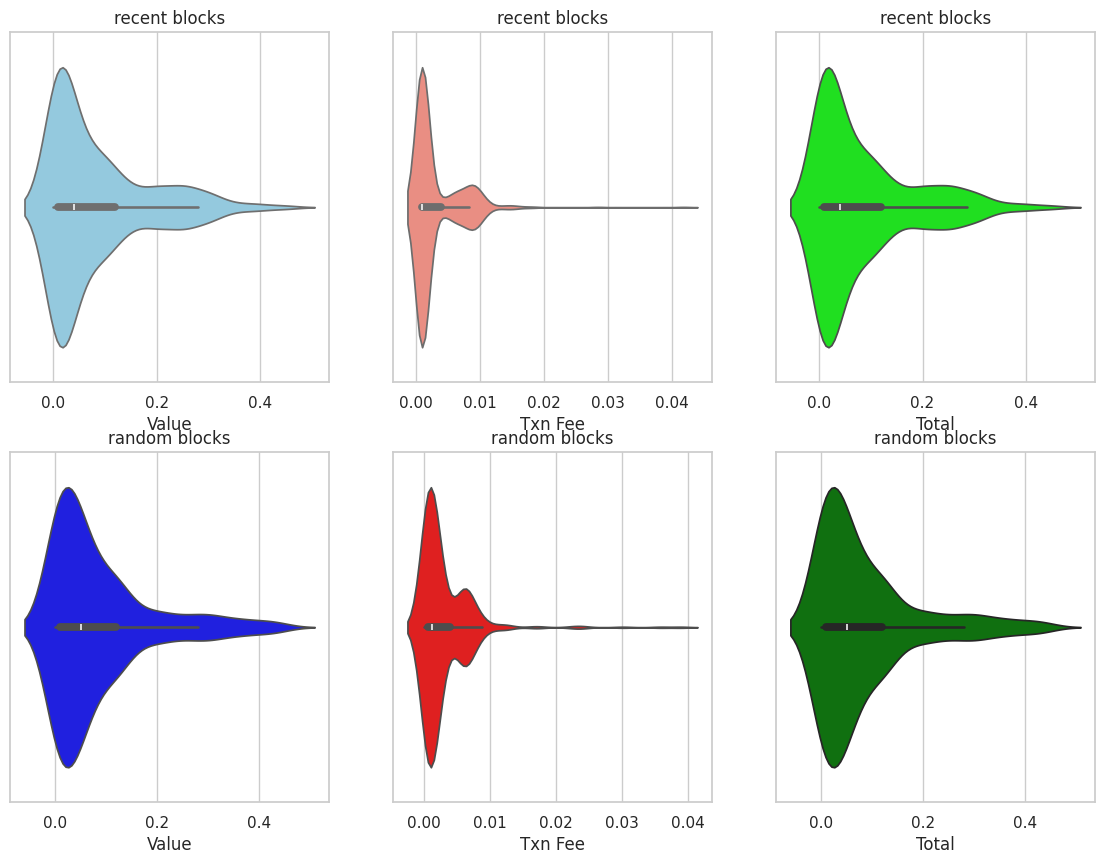

In [170]:
# violin plots
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))

datas = [recent_blocks_df, random_blocks_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
titles = ["recent blocks","random blocks"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.violinplot(x = datas[i//3][coulmns[i%3]], color= colors[i])
    plt.title(titles[i//3])

plt.show()

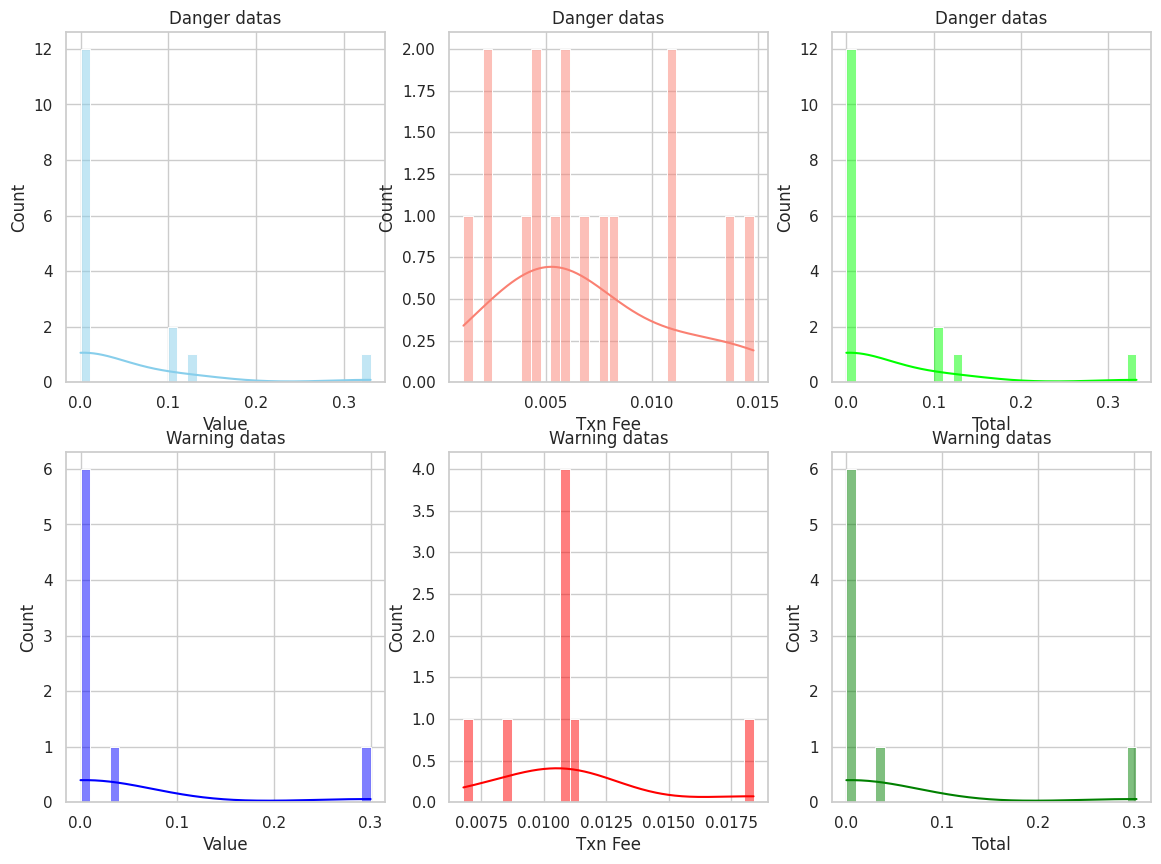

In [182]:
# show hist plot for Danger and Warning datas

danger_df['Total'] = danger_df['Value'] + np.multiply(danger_df['Txn Fee'],danger_df['Value'])
warning_df['Total'] = warning_df['Value'] + np.multiply(warning_df['Txn Fee'],warning_df['Value'])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))

datas = [danger_df, warning_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
titles = ["Danger datas","Warning datas"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.histplot(datas[i//3][coulmns[i%3]], bins=30, kde=True, color= colors[i])
    plt.title(titles[i//3])

plt.show()

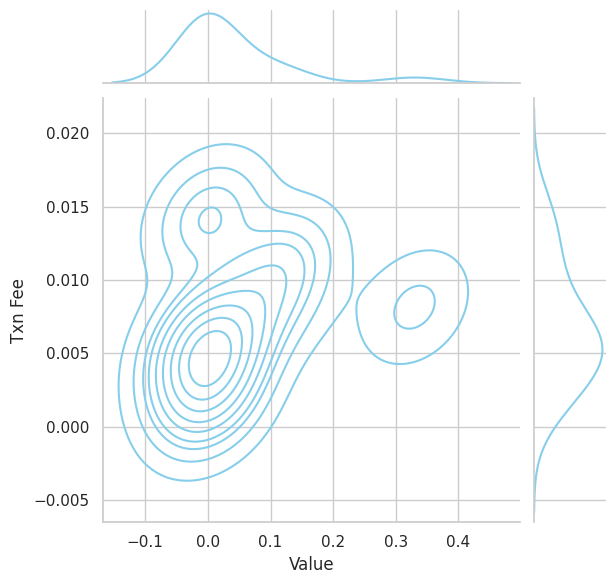

In [197]:
sns.set_theme(style="whitegrid")
sns.jointplot(x="Value", y="Txn Fee", data=danger_df, kind="kde", color = "skyblue")
plt.show()

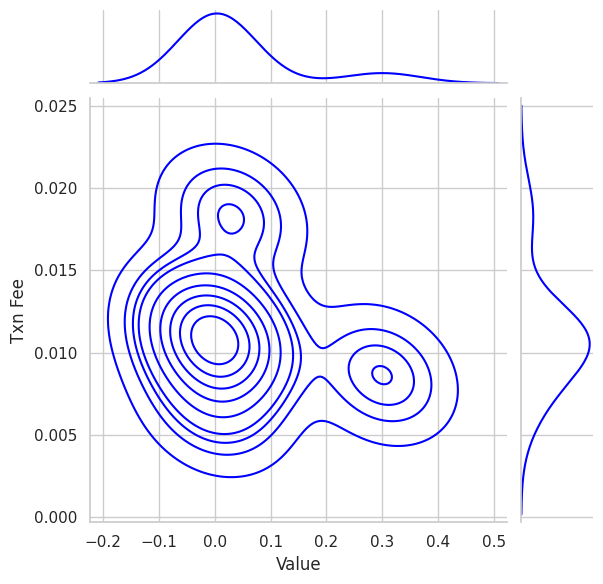

In [198]:
sns.set_theme(style="whitegrid")
sns.jointplot(x="Value", y="Txn Fee", data=warning_df, kind="kde", color = "blue")
plt.show()

## Data Sampling and Analysis

In this section, we will delve into the process of data sampling and perform an initial analysis on the transaction data we have collected. Our objective is to understand the distribution of transaction values by sampling the data and comparing the sample statistics with the population statistics.

### Steps

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by handling missing values, converting data types, and removing any irrelevant information.

3. **Simple Random Sampling (SRS)**: Create a sample from the dataset using a simple random sampling method. This involves randomly selecting a subset of the data without regard to any specific characteristics of the data.

4. **Stratified Sampling**: Create another sample from the dataset using a stratified sampling method. This involves dividing the data into strata based on a specific characteristic (e.g., transaction value) and then randomly selecting samples from each stratum. Explain what you have stratified the data by and why you chose this column.

5. **Statistical Analysis**: Calculate the mean and standard deviation of the samples and the population. Compare these statistics to understand the distribution of transaction values.

6. **Visualization**: Plot the distribution of transaction values and fees for both the samples and the population to visually compare their distributions.

### Considerations

- **Sample Size**: The size of the sample should be large enough to represent the population accurately but not so large that it becomes impractical to analyze.
- **Sampling Method**: Choose the appropriate sampling method based on the characteristics of the data and the research question.

Explain the above considerations in your report.

Population Statistics:
              Value     Txn Fee
count  5.640000e+02  564.000000
mean   8.065195e-02    0.002677
std    9.882480e-02    0.003421
min    8.500000e-08    0.000846
25%    1.007974e-02    0.000943
50%    3.610226e-02    0.000997
75%    1.146600e-01    0.003020
max    4.399559e-01    0.041809

Simple Random Sample Statistics:
              Value     Txn Fee
count  1.000000e+02  100.000000
mean   5.662556e-02    0.002629
std    7.558444e-02    0.002917
min    3.290000e-07    0.000846
25%    8.965475e-03    0.000945
50%    2.753488e-02    0.001021
75%    7.312774e-02    0.002934
max    4.169878e-01    0.013385

Stratified Sample Statistics:
           Value    Txn Fee
count  94.000000  94.000000
mean    0.086203   0.002206
std     0.105499   0.002431
min     0.001260   0.000846
25%     0.012558   0.000943
50%     0.037411   0.000984
75%     0.130000   0.001188
max     0.439956   0.011309


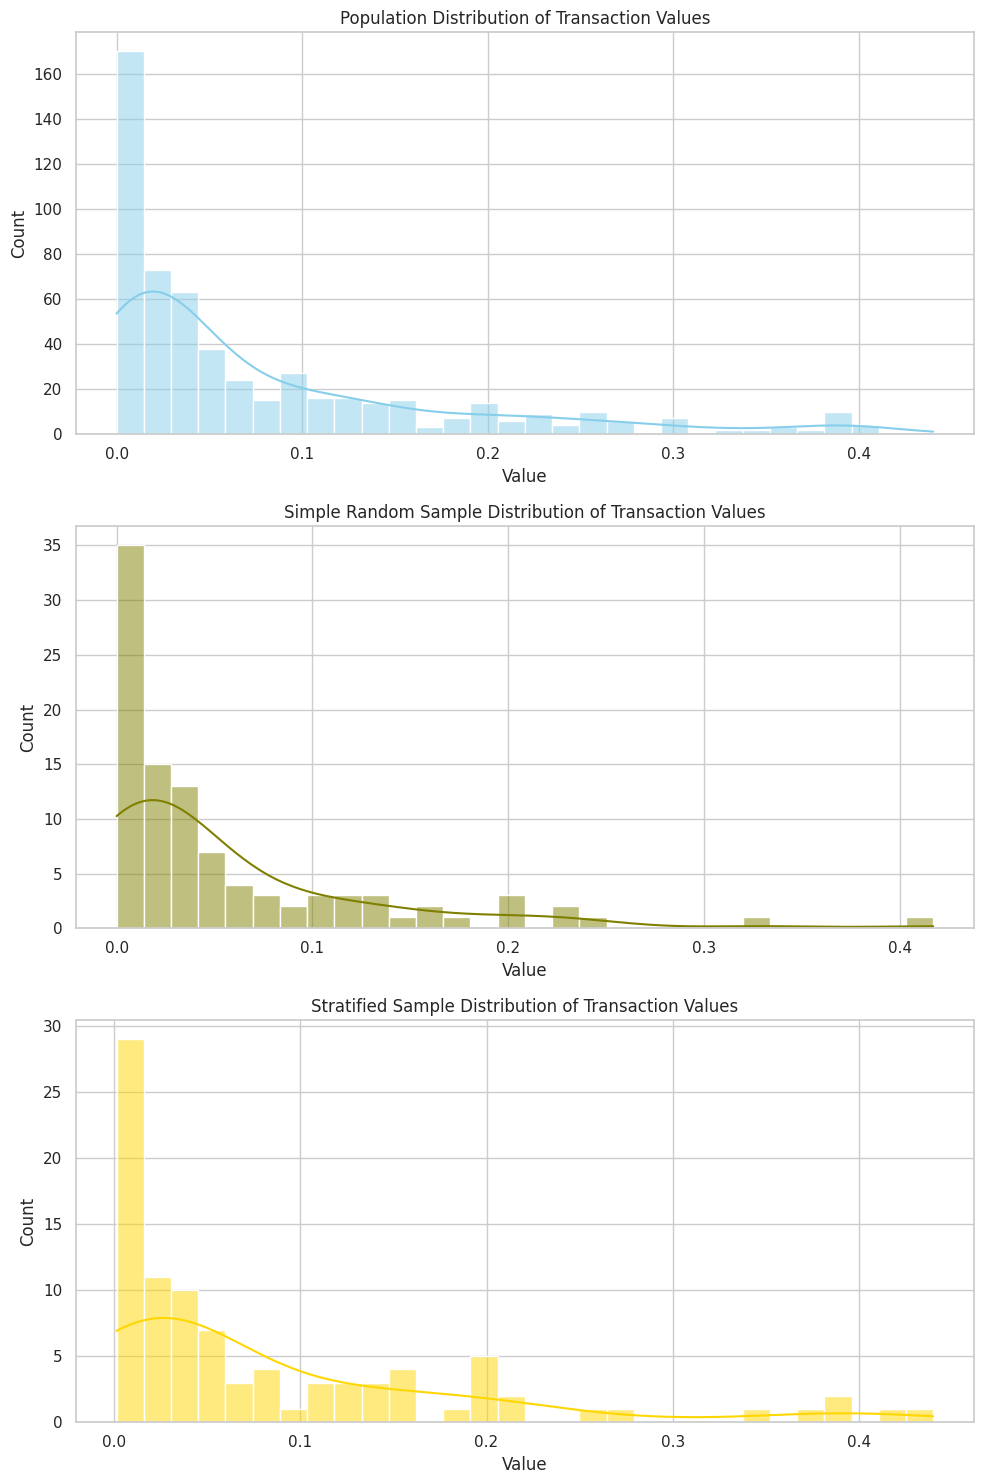

In [21]:
# Load data
df = pd.read_csv('transactions.csv')

# Convert 'Value' and 'Txn Fee' to numeric, forcing non-numeric values to NaN
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df['Txn Fee'] = pd.to_numeric(df['Txn Fee'], errors='coerce')

# Drop rows with NaN in specific columns if conversion resulted in NaN values
df.dropna(subset=['Value', 'Txn Fee'], inplace=True)

# Filtering transactions based on 'Value' and 'Txn Fee' ranges
df = df[((df['Value'] > 0) & (df['Value'] < 0.45)) & ((df['Txn Fee'] > 0) & (df['Txn Fee'] < 0.045))]

# Adding a new column for the sum of 'Value' and 'Txn Fee'
df['Total'] = df['Value'] + np.multiply(df['Txn Fee'],df['Value'])

# Drop duplicates
df.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)

# Simple Random Sampling (SRS)
# Sample size chosen as 100 for demonstration; adjust based on your dataset size and analysis needs
sample_size = 100
srs_sample = df.sample(n=sample_size, random_state=42)

# Stratified Sampling
df['Method'] = df['Method'].astype('category')
strata = df.groupby('Method', group_keys=False)
# Apply proportional sampling within each stratum
stratified_sample = strata.apply(lambda x: x.sample(int(np.rint(sample_size*len(x)/len(df))), random_state=42))

# Statistical Analysis
print("Population Statistics:")
print(df[['Value', 'Txn Fee']].describe())

print("\nSimple Random Sample Statistics:")
print(srs_sample[['Value', 'Txn Fee']].describe())

print("\nStratified Sample Statistics:")
print(stratified_sample[['Value', 'Txn Fee']].describe())

# Visualization
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Population Distribution
sns.histplot(df['Value'], bins=30, kde=True, color="skyblue", ax=axs[0])
axs[0].set_title('Population Distribution of Transaction Values')

# SRS Distribution
sns.histplot(srs_sample['Value'], bins=30, kde=True, color="olive", ax=axs[1])
axs[1].set_title('Simple Random Sample Distribution of Transaction Values')

# Stratified Sample Distribution
sns.histplot(stratified_sample['Value'], bins=30, kde=True, color="gold", ax=axs[2])
axs[2].set_title('Stratified Sample Distribution of Transaction Values')

plt.tight_layout()
plt.show()